In [36]:
#データの読み込み
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.neighbors import KNeighborsClassifier as KN
import seaborn as sns

def datamake(train):
    train.index = pd.to_datetime(train["datetime"])
    train["kcal"] = train["kcal"].fillna("なし")
    train["remarks"] = train["remarks"].fillna("なし")
    train["event"] = train["event"].fillna("なし")
    train["payday"] = train["payday"].fillna(0)
    train["precipitation"] = train["precipitation"].apply(lambda x : -1 if x == "--" else float(x) )
    train["month"] = train["datetime"].apply(lambda x :int(x.split("-")[1]))
    train["fun"] = train["remarks"].apply(lambda x: 1 if x=="お楽しみメニュー" else 0)
    train["kodawari"] = train["remarks"].apply(lambda x: 1 if x=="料理長のこだわりメニュー" else 0)
    train["curry"] = train["name"].apply(lambda x : 1 if x.find("カレー")>=0 else 0)
    train["chiken"] = train["name"].apply(lambda x : 1 if x.find("チキン")>=0 else 0)
    train["katu"] = train["name"].apply(lambda x : 1 if x.find("カツ")>=0 else 0)
    train["chiken"] = train["name"].apply(lambda x : 1 if x.find("チキン")>=0 else 0)
    train["days"] = [i for i in range(len(train))]
    train["Wednesday1"] = train["week"].apply(lambda x :wednesday(x))  
    train["event1"] = train["event"].apply(lambda x :event(x))  
    train["menyu1"] = train["remarks"].apply(lambda x :menyu(x))  
    train["payday1"] = train["payday"].apply(lambda x :payday(x)) 
    return train
    
def cluster(x):
    if x >= 1.135743e+01:
        return 1
    elif x< -1.318539e+01:
        return -1
    else:
        return 0

def wednesday(X):
    if X=="水":
        return 0
    elif X=="月":
        return 1
    elif X=="火":
        return 1
    elif X=="木":
        return -1
    else:
        return 100

def event(X):
    if X == "キャリアアップ支援セミナー":
        return 1
    elif X == "ママの会":
        return -0.5
    else:
        return 0

def menyu(X):
    if X == "鶏のレモンペッパー焼（50食）、カレー（42食）":
        return -1
    elif X == "酢豚（28食）、カレー（85食）":
        return 0
    elif X == "お楽しみメニュー":
        return 1
    elif X == "料理長のこだわりメニュー":
        return 0
    elif X == "手作りの味":
        return 1
    elif X == "スペシャルメニュー（800円）":
        return 0
    else:
        return -0.5

def payday(X):
    if X == 0:
        return 0
    else:
        return 2



In [37]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv",header=None)

In [38]:
train["t"] = 1
test["t"] = 0
dat = pd.concat([train,test],sort=True).reset_index(drop=True)

In [39]:
dat = datamake(dat)

In [40]:
dat["days"] = [i for i in range(len(dat))]

In [41]:
dat_d = pd.get_dummies(dat[["Wednesday1", "event1", "menyu1", "payday1",
                                 "precipitation","kodawari", "curry", "katu",
                                 "chiken", "soldout","t"]])

In [42]:
train = dat[dat["t"]==1]
test = dat[dat["t"]==0]

In [43]:
model1 = LR()
train_X1, train_Y1 = train["days"].values.reshape(-1,1), train["y"]
model1.fit(train_X1, train_Y1)
pred1 = model1.predict(train_X1)


train_X = dat_d[dat_d["t"]==1]


In [44]:
print(train.columns.values)

['datetime' 'event' 'kcal' 'name' 'payday' 'precipitation' 'remarks'
 'soldout' 't' 'temperature' 'weather' 'week' 'y' 'month' 'fun' 'kodawari'
 'curry' 'chiken' 'katu' 'days' 'Wednesday1' 'event1' 'menyu1' 'payday1']


In [45]:
train_Y = train["y"] - pred1

In [46]:
train = train.assign(D=0)#エラーが発生しているためやむを得ず

In [47]:
train["D"] = train_Y.apply(lambda x :cluster(x))

0.5990338164251208


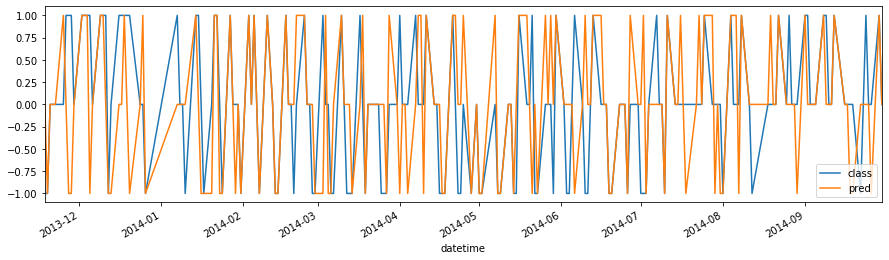

In [48]:
model2 = KN()
model2.fit(train_X, train["D"])
y = model2.predict(train_X)
g1 = pd.DataFrame({"class":train["D"],"pred":y})
g1.plot(figsize=(15,4))
print(model2.score(train_X, train["D"]))

In [49]:
dat = dat.assign(aid=0)#エラーが発生しているためやむを得ず
y = model2.predict(dat_d)
dat["aid"] = y

In [50]:
dat_d2 = pd.get_dummies(dat[["fun", "curry","weather", "aid","temperature","t"]])

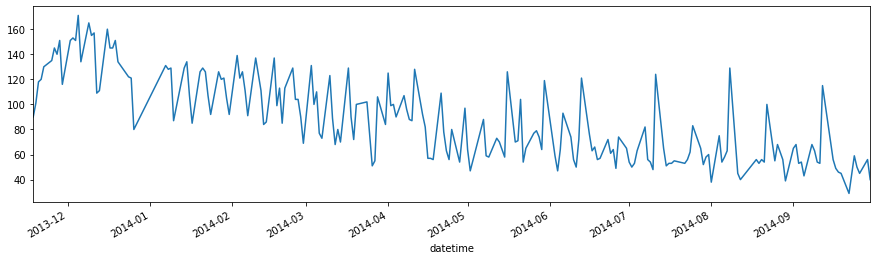

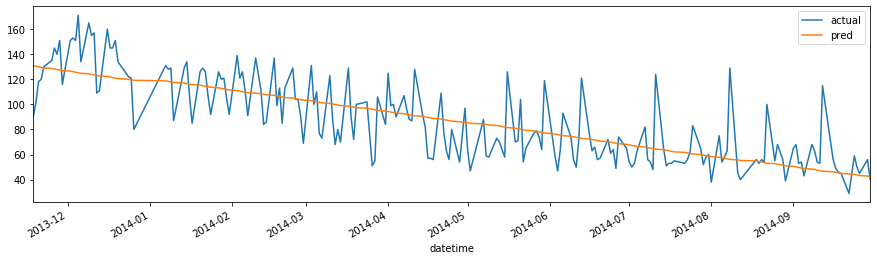

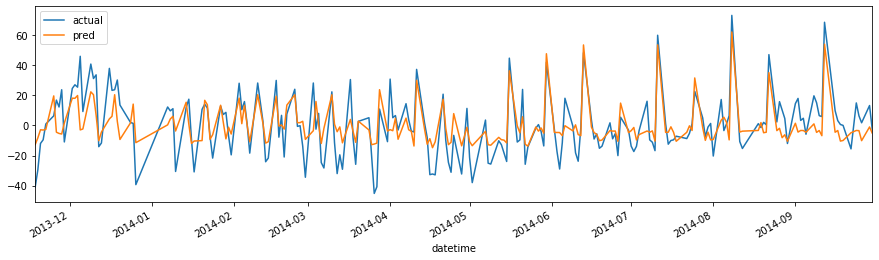

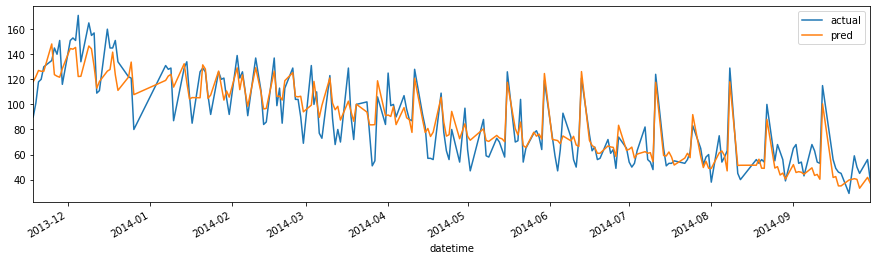

In [51]:
##試運転

model6 = LR()
train_X3, train_Y3 = train["days"].values.reshape(-1,1), train["y"]
model6.fit(train_X3, train_Y3)

model7 = RF(n_estimators=500,max_depth=4,random_state=777)

train_X4= dat_d2[dat_d2["t"]==1]
train["pred"] = model6.predict(train_X3)
train_Y4 = train["y"] - train["pred"]
model7.fit(train_X4, train_Y4)

train_Y3.plot(figsize=(15,4))
v0 =  model6.predict(train_X3)
p0 = pd.DataFrame({"actual":train_Y3,"pred":v0})
p0.plot(figsize=(15,4))
v1 =  model7.predict(train_X4)
p1 = pd.DataFrame({"actual":train_Y4,"pred":v1})
p1.plot(figsize=(15,4))

v2 =  model6.predict(train_X3) + model7.predict(train_X4)
p22 = pd.DataFrame({"actual":train["y"],"pred":v2})
p22.plot(figsize=(15,4))
plt.legend()


In [52]:
test = dat[dat["t"]==0]
test_X1 = test["days"].values.reshape(-1,1)
model1.predict(test_X1)

array([41.98775855, 41.55857172, 41.1293849 , 40.70019807, 40.27101125,
       39.84182442, 39.41263759, 38.98345077, 38.55426394, 38.12507712,
       37.69589029, 37.26670347, 36.83751664, 36.40832982, 35.97914299,
       35.54995616, 35.12076934, 34.69158251, 34.26239569, 33.83320886,
       33.40402204, 32.97483521, 32.54564839, 32.11646156, 31.68727473,
       31.25808791, 30.82890108, 30.39971426, 29.97052743, 29.54134061,
       29.11215378, 28.68296696, 28.25378013, 27.8245933 , 27.39540648,
       26.96621965, 26.53703283, 26.107846  , 25.67865918, 25.24947235])

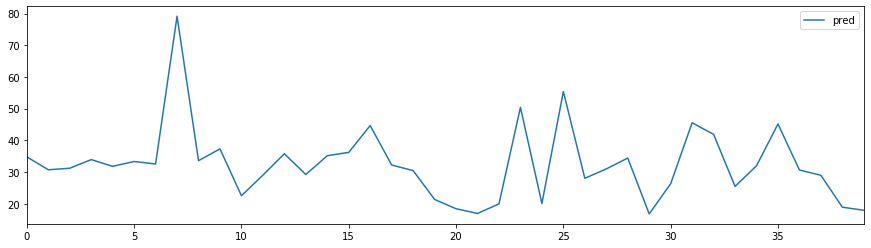

In [53]:
##試運転
test_X2= dat_d2[dat_d2["t"]==0]


v2 =  model1.predict(test_X1) + model7.predict(test_X2)
p22 = pd.DataFrame({"pred":v2})
p22.plot(figsize=(15,4))
plt.legend()


In [54]:
sample[1] = v2
sample.to_csv("submit8.csv",index=None,header=None)

In [55]:
len(sample),len(v2)

(40, 40)

## 結果として評価値は「23.5」と悪化した
- 今回は過学習を無視した形で組んでいったため、ここから過学習を考慮して考えてみることにする。
- 手始めに、ここからノイズの多いデータが多分に含まれていることが分かるため、Χ二乗検定などを用いてそぎ落とすことに。
- 検査する要素は["y"]と["fun", "curry","weather", "aid","temperature","t"]
- とりあえず5%で試しに検証

In [56]:
crossed = pd.crosstab(dat["y"], dat["Wednesday1"])

In [57]:
import scipy as sp
import scipy.stats

x2, p, dof, expected = sp.stats.chi2_contingency(crossed)

print("カイ二乗値は %(x2)s" %locals() )
print("確率は %(p)s" %locals() )
print("自由度は %(dof)s" %locals() )


if p < 0.05:
    print("有意な差があります")
else:
    print("有意な差がありません")

カイ二乗値は 269.4295521510891
確率は 0.64860920420231
自由度は 279
有意な差がありません


In [58]:
crossed = pd.crosstab(dat["y"], dat["aid"])
x2, p, dof, expected = sp.stats.chi2_contingency(crossed)

print("カイ二乗値は %(x2)s" %locals() )
print("確率は %(p)s" %locals() )
print("自由度は %(dof)s" %locals() )


if p < 0.05:
    print("有意な差があります")
else:
    print("有意な差がありません")

カイ二乗値は 191.48912287293422
確率は 0.37587405319472017
自由度は 186
有意な差がありません


In [59]:
crossed = pd.crosstab(dat["y"], dat["weather"])
x2, p, dof, expected = sp.stats.chi2_contingency(crossed)

print("カイ二乗値は %(x2)s" %locals() )
print("確率は %(p)s" %locals() )
print("自由度は %(dof)s" %locals() )


if p < 0.05:
    print("有意な差があります")
else:
    print("有意な差がありません")

カイ二乗値は 618.5512601384464
確率は 0.03831065529015019
自由度は 558
有意な差があります


In [60]:
crossed = pd.crosstab(dat["y"], dat["curry"])
x2, p, dof, expected = sp.stats.chi2_contingency(crossed)

print("カイ二乗値は %(x2)s" %locals() )
print("確率は %(p)s" %locals() )
print("自由度は %(dof)s" %locals() )


if p < 0.05:
    print("有意な差があります")
else:
    print("有意な差がありません")

カイ二乗値は 123.09290247678018
確率は 0.020035115442683465
自由度は 93
有意な差があります


In [61]:
crossed = pd.crosstab(dat["y"], dat["temperature"])
x2, p, dof, expected = sp.stats.chi2_contingency(crossed)

print("カイ二乗値は %(x2)s" %locals() )
print("確率は %(p)s" %locals() )
print("自由度は %(dof)s" %locals() )


if p < 0.05:
    print("有意な差があります")
else:
    print("有意な差がありません")

カイ二乗値は 13776.22711038961
確率は 0.4690370244401713
自由度は 13764
有意な差がありません


In [62]:
crossed = pd.crosstab(dat["y"], dat["fun"])
x2, p, dof, expected = sp.stats.chi2_contingency(crossed)

print("カイ二乗値は %(x2)s" %locals() )
print("確率は %(p)s" %locals() )
print("自由度は %(dof)s" %locals() )


if p < 0.05:
    print("有意な差があります")
else:
    print("有意な差がありません")

カイ二乗値は 114.52673076923077
確率は 0.06440018146882003
自由度は 93
有意な差がありません


## 念のため、clusterについてのΧ二乗検定も行っておく。
- 比較するのはtrain["D"]とtrain["Wednesday1", "event1", "menyu1", "payday1",
     "precipitation","kodawari", "curry", "katu",
     "chiken", "soldout"]


In [68]:
V = ["Wednesday1", "event1", "menyu1", "payday1",
     "precipitation","kodawari", "curry", "katu",
     "chiken", "soldout"]

for i in V:
    crossed = pd.crosstab(train["D"], train[i])
    x2, p, dof, expected = sp.stats.chi2_contingency(crossed)

    if p < 0.05:
        print("Dと",i,"とには、有意な差があります")
    else:
        print("Dと",i,"とには、有意な差がありません")

Dと Wednesday1 とには、有意な差があります
Dと event1 とには、有意な差がありません
Dと menyu1 とには、有意な差があります
Dと payday1 とには、有意な差がありません
Dと precipitation とには、有意な差がありません
Dと kodawari とには、有意な差がありません
Dと curry とには、有意な差があります
Dと katu とには、有意な差がありません
Dと chiken とには、有意な差がありません
Dと soldout とには、有意な差がありません


## 今後の流れ
- 確認の仕方が理解できたため、trainデータをtrain, testに分割し学習させる。
- 過学習を抑える流れに向かう。
- 次辺りで完成を目指したい。